# Solving Multi-armed Bandit Problems

We will focus on how to solve the multi-armed bandit problem using four strategies, including epsilon-greedy, softmax exploration, upper confidence bound, and Thompson sampling. We will see how they deal with the exploration-exploitation dilemma in their own unique ways. We will also work on a billion-dollar problem, online advertising, and demonstrate how to solve it using a multi-armed bandit algorithm. Finally, we will solve the contextual advertising problem using contextual bandits to make more informed decisions in ad optimization.

## Creating a multi-armed bandit environment

The multi-armed bandit problem is one of the simplest reinforcement learning problems. It is best described as a slot machine with multiple levers (arms), and each lever has a different payout and payout probability. Our goal is to discover the best lever with the maximum return so that we can keep choosing it afterward. Let’s start with a simple multi-armed bandit problem in which the payout and payout probability is fixed for each arm. After creating the environment, we will solve it using the random policy algorithm.

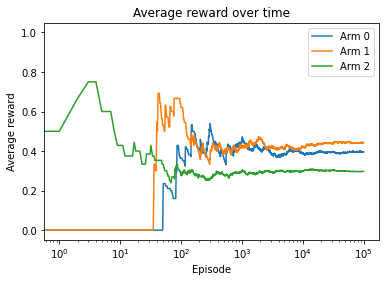

In [ ]:
import torch


class BanditEnv():
    """
    Multi-armed bandit environment
    payout_list:
        A list of probabilities of the likelihood that a particular bandit will pay out
    reward_list:
        A list of rewards of the payout that bandit has
    """
    def __init__(self, payout_list, reward_list):
        self.payout_list = payout_list
        self.reward_list = reward_list

    def step(self, action):
        if torch.rand(1).item() < self.payout_list[action]:
            return self.reward_list[action]
        return 0



if __name__ == "__main__":
    bandit_payout = [0.1, 0.15, 0.3]
    bandit_reward = [4, 3, 1]
    bandit_env = BanditEnv(bandit_payout, bandit_reward)

    n_episode = 100000
    n_action = len(bandit_payout)
    action_count = [0 for _ in range(n_action)]
    action_total_reward = [0 for _ in range(n_action)]
    action_avg_reward = [[] for action in range(n_action)]

    def random_policy():
        action = torch.multinomial(torch.ones(n_action), 1).item()
        return action

    for episode in range(n_episode):
        action = random_policy()
        reward = bandit_env.step(action)
        action_count[action] += 1
        action_total_reward[action] += reward
        for a in range(n_action):
            if action_count[a]:
                action_avg_reward[a].append(action_total_reward[a] / action_count[a])
            else:
                action_avg_reward[a].append(0)


    import matplotlib.pyplot as plt
    
    for action in range(n_action):
        plt.plot(action_avg_reward[action])

    plt.legend(['Arm {}'.format(action) for action in range(n_action)])
    plt.xscale('log')
    plt.title('Average reward over time')
    plt.xlabel('Episode')
    plt.ylabel('Average reward')
    plt.show()

In the example we just worked on, there are three slot machines. Each machine has a different payout (reward) and payout probability. In each episode, we randomly chose one arm of the machine to pull (one action to execute) and get a payout at a certain probability.



Arm 1 is the best arm with the largest average reward. Also, the average rewards start to saturate round 10,000 episodes.

This solution seems very naive as we only perform an exploration of all arms. We will come up with more intelligent strategies in the upcoming sections.

## Solving multi-armed bandit problems with the epsilon-greedy policy

Instead of exploring solely with random policy, we can do better with a combination of exploration and exploitation. Here comes the well-known epsilon-greedy policy.

Epsilon-greedy for multi-armed bandits exploits the best action the majority of the time and also keeps exploring different actions from time to time. Given a parameter, ε, with a value from 0 to 1, the probabilities of performing exploration and exploitation are ε and 1 - ε, respectively.


Similar to other MDP problems, the epsilon-greedy policy selects the best arm with a probability of 1 - ε and performs random exploration with a probability of ε. Epsilon manages the trade-off between exploration and exploitation.

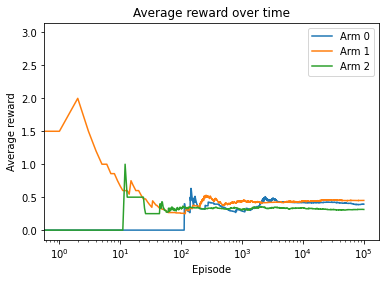

In [ ]:
import torch

bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [4, 3, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

n_episode = 100000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]


def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(Q):
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

epsilon = 0.2

epsilon_greedy_policy = gen_epsilon_greedy_policy(n_action, epsilon)


Q = torch.zeros(n_action)

for episode in range(n_episode):
    action = epsilon_greedy_policy(Q)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)


import matplotlib.pyplot as plt
for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()



Arm 1 is the best arm, with the largest average reward at the end. Also, its average reward starts to saturate after around 1,000 episodes.

You may wonder whether the epsilon-greedy policy actually outperforms the random policy. Besides the fact that the value for the optimal arm converges earlier with the epsilon-greedy policy, we can also prove that, on average, the reward we get during the course of training is higher with the epsilon-greedy policy than the random policy.

We can simply average the reward over all episodes:

In [ ]:
print(sum(action_total_reward) / n_episode)

0.43616


Over 100,000 episodes, the average payout is 0.43718 with the epsilon-greedy policy. Repeating the same computation for the random policy solution, we get 0.37902 as the average payout.

## Solving multi-armed bandit problems with the softmax exploration

As we've seen with epsilon-greedy, when performing exploration we randomly select one of the non-best arms with a probability of ε/|A|. Each non-best arm is treated equivalently regardless of its value in the Q function. Also, the best arm is chosen with a fixed probability regardless of its value. In softmax exploration, an arm is chosen based on a probability from the softmax distribution of the Q function values.

With the softmax exploration strategy, the dilemma of exploitation and exploration is solved with a softmax function based on the Q values. Instead of using a fixed pair of probabilities for the best arm and non-best arms, it adjusts the probabilities according to the softmax distribution with the τ parameter as a temperature factor. The higher the value of τ, the more focus will be shifted to exploration.

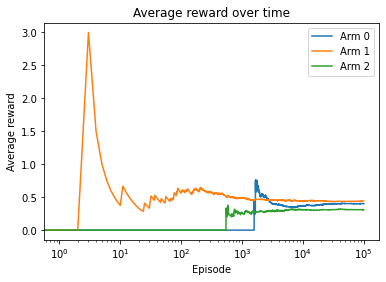

In [ ]:
import torch

bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [4, 3, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

n_episode = 100000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]



def gen_softmax_exploration_policy(tau):
    def policy_function(Q):
        probs = torch.exp(Q / tau)
        probs = probs / torch.sum(probs)
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

tau = 0.1

softmax_exploration_policy = gen_softmax_exploration_policy(tau)

Q = torch.zeros(n_action)

for episode in range(n_episode):
    action = softmax_exploration_policy(Q)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]

    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)


import matplotlib.pyplot as plt
for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

Arm 1 is the best arm, with the largest average reward at the end. Also, its average reward starts to saturate after around 800 episodes in this example.

## Solving multi-armed bandit problems with the upper confidence bound algorithm

In the previous two recipes, we explored random actions in the multi-armed bandit problem with probabilities that are either assigned as fixed values in the epsilon-greedy policy or computed based on the Q-function values in the softmax exploration algorithm. In either algorithm, the probabilities of taking random actions are not adjusted over time. Ideally, we want less exploration as learning progresses. In this recipe, we will use a new algorithm called upper confidence bound to achieve this goal.

The upper confidence bound (UCB) algorithm stems from the idea of the confidence interval. In general, the confidence interval is a range of values where the true value lies. In the UCB algorithm, the confidence interval for an arm is a range where the mean reward obtained with this arm lies. The interval is in the form of [lower confidence bound, upper confidence bound] and we only use the upper bound, which is the UCB, to estimate the potential of the arm. The UCB is computed as follows:

$$UCB(a) = Q(a) + \sqrt{2log(t)/N(a)}$$

Here, t is the number of episodes, and N(a) is the number of times arm a is chosen among t episodes. As learning progresses, the confidence interval shrinks and becomes more and more accurate. The arm to pull is the one with the highest UCB.

In this recipe, we solved the multi-armed bandit with the UCB algorithm. It adjusts the exploitation-exploration dilemma according to the number of episodes. For an action with a few data points, its confidence interval is relatively wide, hence, choosing this action is of relatively high uncertainty. With more episodes of the action being selected, the confidence interval becomes narrow and shrinks to its actual value. In this case, it is of high certainty to choose (or not) this action. Finally, the UCB algorithm pulls the arm with the highest UCB in each episode and gains more and more confidence over time.



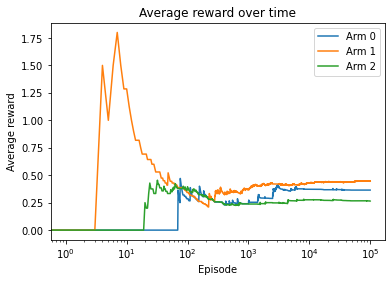

In [ ]:
import torch

bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [4, 3, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

n_episode = 100000
n_action = len(bandit_payout)
action_count = torch.tensor([0. for _ in range(n_action)])
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]



def upper_confidence_bound(Q, action_count, t):
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / action_count) + Q
    return torch.argmax(ucb)



Q = torch.empty(n_action)

for episode in range(n_episode):
    action = upper_confidence_bound(Q, action_count, episode)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]

    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)


import matplotlib.pyplot as plt
for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

Arm 1 is the best arm, with the largest average reward in the end.

You may wonder whether UCB actually outperforms the epsilon-greedy policy. We can compute the average reward over the entire training process, and the policy with the highest average reward learns faster.

We can simply average the reward over all episodes:

In [ ]:
print(sum(action_total_reward) / n_episode)

0.4433


Over 100,000 episodes, the average payout is 0.44605 with UCB, which is higher than 0.43718 with the epsilon-greedy policy.

## Solving internet advertising problems with a multi-armed bandit

Imagine you are an advertiser working on ad optimization on a website:

- There are three different colors of ad background – red, green, and blue. Which one will achieve the best click-through rate (CTR)?
- There are three types of wordings of the ad – learn …, free ..., and try .... Which one will achieve the best CTR?

For each visitor, we need to choose an ad in order to maximize the CTR over time. How can we solve this?

Perhaps you are thinking about A/B testing, where you randomly split the traffic into groups and assign each ad to a different group, and then choose the ad from the group with the highest CTR after a period of observation. However, this is basically a complete exploration, and we are usually unsure of how long the observation period should be and will end up losing a large portion of potential clicks. Besides, in A/B testing, the unknown CTR for an ad is assumed to not change over time. Otherwise, such A/B testing should be re-run periodically.

A multi-armed bandit can certainly do better than A/B testing. Each arm is an ad, and the reward for an arm is either 1 (click) or 0 (no click).

Let's try to solve it with the UCB algorithm.


In this recipe, we solved the ad optimization problem in a multi-armed bandit manner. It overcomes the challenges confronting the A/B testing approach. We used the UCB algorithm to solve the multi-armed (multi-ad) bandit problem; the reward for each arm is either 1 or 0. Instead of pure exploration and no interaction between action and reward, UCB (or other algorithms such as epsilon-greedy and softmax exploration) dynamically switches between exploitation and exploration where necessarly. For an ad with a few data points, the confidence interval is relatively wide, hence, choosing this action is of relatively high uncertainty. With more episodes of the ad being selected, the confidence interval becomes narrow and shrinks to its actual value.

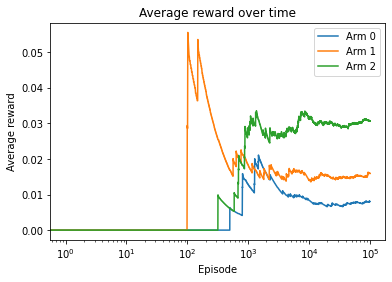

In [ ]:
import torch

bandit_payout = [0.01, 0.015, 0.03]
bandit_reward = [1, 1, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

n_episode = 100000
n_action = len(bandit_payout)
action_count = torch.tensor([0. for _ in range(n_action)])
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]



def upper_confidence_bound(Q, action_count, t):
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / action_count) + Q
    return torch.argmax(ucb)



Q = torch.empty(n_action)

for episode in range(n_episode):
    action = upper_confidence_bound(Q, action_count, episode)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]

    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)


import matplotlib.pyplot as plt
for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

Ad 2 is the best ad with the highest predicted CTR (average reward) after the model converges.

Eventually, we found that ad 2 is the optimal one to choose, which is true. Also, the sooner we figure this out the better, because we will lose fewer potential clicks. In this example, ad 2 outperformed the others after around 1000 episodes.

## Solving multi-armed bandit problems with the Thompson sampling algorithm

In this recipe, we will tackle the exploitation and exploration dilemma in the advertising bandits problem using another algorithm, Thompson sampling. We will see how it differs greatly from the previous three algorithms.

Thompson sampling (TS) is also called Bayesian bandits as it applies the Bayesian way of thinking from the following perspectives:

- It is a probabilistic algorithm.
- It computes the prior distribution for each arm and samples a value from each distribution.
- It then selects the arm with the highest value and observes the reward.
- Finally, it updates the prior distribution based on the observed reward. This process is called Bayesian updating.

As we have seen that in our ad optimization case, the reward for each arm is either 1 or 0. We can use beta distribution for our prior distribution because the value of the beta distribution is from 0 to 1. The beta distribution is parameterized by two parameters, α and β. α represents the number of times we receive the reward of 1 and β, indicates the number of times we receive the reward of 0.

To help you understand the beta distribution better, we will start by looking at several beta distributions before we implement the TS algorithm.

In [ ]:
import torch
import matplotlib.pyplot as plt

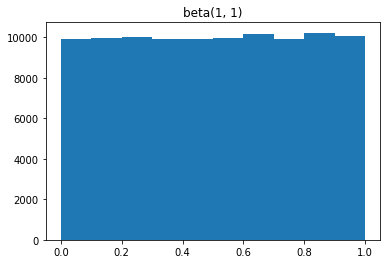

In [ ]:
beta1 = torch.distributions.beta.Beta(1, 1)
samples1 = [beta1.sample() for _ in range(100000)]
plt.hist(samples1, range=[0, 1], bins=10)
plt.title('beta(1, 1)')
plt.show()

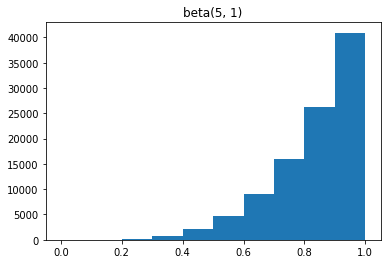

In [ ]:
beta2 = torch.distributions.beta.Beta(5, 1)
samples2 = [beta2.sample() for _ in range(100000)]
plt.hist(samples2, range=[0, 1], bins=10)
plt.title('beta(5, 1)')
plt.show()

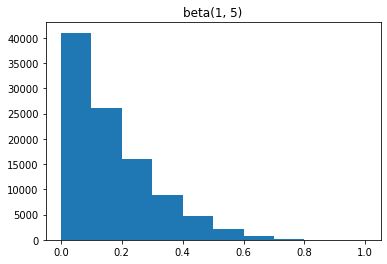

In [ ]:
beta3 = torch.distributions.beta.Beta(1, 5)
samples3= [beta3.sample() for _ in range(100000)]
plt.hist(samples3, range=[0, 1], bins=10)
plt.title('beta(1, 5)')
plt.show()

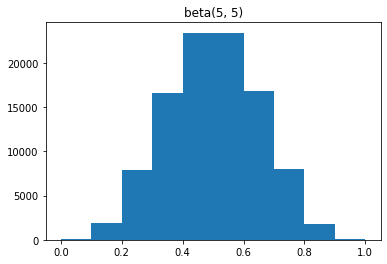

In [ ]:
beta4 = torch.distributions.beta.Beta(5, 5)
samples4= [beta4.sample() for _ in range(100000)]
plt.hist(samples4, range=[0, 1], bins=10)
plt.title('beta(5, 5)')
plt.show()

In [ ]:
bandit_payout = [0.01, 0.015, 0.03]
bandit_reward = [1, 1, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

n_episode = 100000
n_action = len(bandit_payout)
action_count = torch.tensor([0. for _ in range(n_action)])
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]

In this recipe, we solved the ad bandits problem with the TS algorithm. The biggest difference between TS and the three other approaches is the adoption of Bayesian optimization. It first computes the prior distribution for each possible arm, and then randomly draws a value from each distribution. It then picks the arm with the highest value and uses the observed outcome to update the prior distribution. The TS policy is both stochastic and greedy. If an ad is more likely to receive clicks, its beta distribution shifts toward 1 and, hence, the value of a random sample tends to be closer to 1.



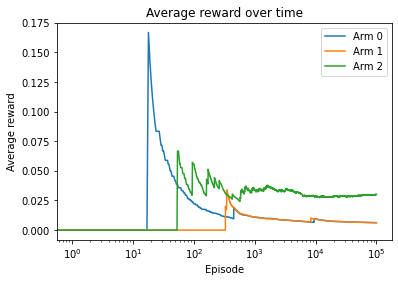

In [ ]:
def thompson_sampling(alpha, beta):
    prior_values = torch.distributions.beta.Beta(alpha, beta).sample()
    return torch.argmax(prior_values)


alpha = torch.ones(n_action)
beta = torch.ones(n_action)


for episode in range(n_episode):
    action = thompson_sampling(alpha, beta)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward

    if reward > 0:
        alpha[action] += 1
    else:
        beta[action] += 1

    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(action_total_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)



for action in range(n_action):
    plt.plot(action_avg_reward[action])

plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.xscale('log')
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

Ad 2 is the best ad, with the highest predicted CTR (average reward).

## Solving internet advertising problems with contextual bandits

You may notice that in the ad optimization problem, we only care about the ad and ignore other information, such as user information and web page information, that might affect the ad being clicked on or not. In this recipe, we will talk about how we take more information into account beyond the ad itself and solve the problem with contextual bandits.

The multi-armed bandit problems we have worked with so far do not involve the concept of state, which is very different from MDPs. We only have several actions, and a reward will be generated that is associated with the action selected. Contextual bandits extend multi-armed bandits by introducing the concept of state. State provides a description of the environment, which helps the agent take more informed actions. In the advertising example, the state could be the user's gender (two states, male and female), the user’s age group (four states, for example), or page category (such as sports, finance, or news). Intuitively, users of certain demographics are more likely to click on an ad on certain pages.

It is not difficult to understand contextual bandits. A multi-armed bandit is a single machine with multiple arms, while contextual bandits are a set of such machines (bandits). Each machine in contextual bandits is a state that has multiple arms. The learning goal is to find the best arm (action) for each machine (state).

We will work with an advertising example with two states for simplicity.

In this recipe, we solved the contextual advertising problem with contextual bandits using the UCB algorithm.

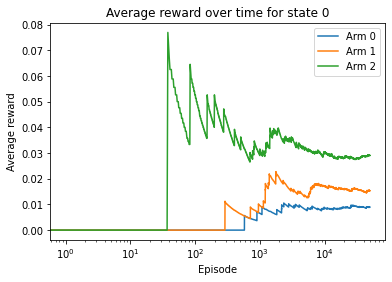

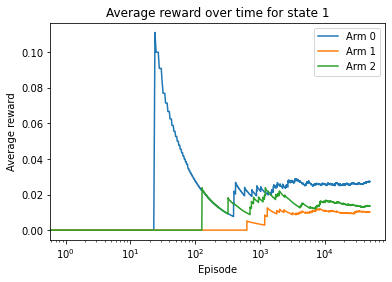

In [ ]:
import torch

bandit_payout_machines = [
    [0.01, 0.015, 0.03],
    [0.025, 0.01, 0.015]
]
bandit_reward_machines = [
    [1, 1, 1],
    [1, 1, 1]
]
n_machine = len(bandit_payout_machines)

bandit_env_machines = [BanditEnv(bandit_payout, bandit_reward)
                       for bandit_payout, bandit_reward in
                       zip(bandit_payout_machines, bandit_reward_machines)]

n_episode = 100000
n_action = len(bandit_payout_machines[0])
action_count = torch.zeros(n_machine, n_action)
action_total_reward = torch.zeros(n_machine, n_action)
action_avg_reward = [[[] for action in range(n_action)] for _ in range(n_machine)]



def upper_confidence_bound(Q, action_count, t):
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / action_count) + Q
    return torch.argmax(ucb)



Q_machines = torch.empty(n_machine, n_action)

for episode in range(n_episode):
    state = torch.randint(0, n_machine, (1,)).item()

    action = upper_confidence_bound(Q_machines[state], action_count[state], episode)
    reward = bandit_env_machines[state].step(action)
    action_count[state][action] += 1
    action_total_reward[state][action] += reward
    Q_machines[state][action] = action_total_reward[state][action] / action_count[state][action]

    for a in range(n_action):
        if action_count[state][a]:
            action_avg_reward[state][a].append(action_total_reward[state][a] / action_count[state][a])
        else:
            action_avg_reward[state][a].append(0)


import matplotlib.pyplot as plt

for state in range(n_machine):
    for action in range(n_action):
        plt.plot(action_avg_reward[state][action])
    plt.legend(['Arm {}'.format(action) for action in range(n_action)])
    plt.xscale('log')
    plt.title('Average reward over time for state {}'.format(state))
    plt.xlabel('Episode')
    plt.ylabel('Average reward')
    plt.show()

Given the first state, ad 2 is the best ad, with the highest predicted CTR. Given the second state, ad 0 is the optimal ad, with the highest average reward. And these are both true.

Contextual bandits are a set of multi-armed bandits. Each bandit represents a unique state of the environment. The state provides a description of the environment, which helps the agent take more informed actions. In our advertising example, male users might be more likely to click an ad than female users. We simply used two slot machines to incorporate two states and searched for the best arm to pull given each state.

One thing to note is that contextual bandits are still different from MDPs, although they involve the concept of state. First, the states in contextual bandits are not determined by the previous actions or states, but are simply observations of the environment. Second, there is no delayed or discounted reward in contextual bandits because a bandit episode is one step. However, compared to multi-armed bandits, contextual bandits are closer to MDP as the actions are conditional to the states in the environment. It is safe to say that contextual bandits are in between multi-armed bandits and full MDP reinforcement learning.